#  **Hyperparameter Tuning and Image Augmentation for CNN**

 This Jupyter notebook encompasses two primary tasks:

1. **Hyperparameter Tuning:** This section focuses on optimizing the architecture and training parameters of a Convolutional Neural Network (CNN) using Keras Tuner. The goal is to find the best combination of hyperparameters to enhance model performance.

2. **Image Augmentation and Model Training:** This part involves applying image augmentation technique to the training data to improve model generalization. After augmentation, the model is trained on the augmented dataset. Finally, both the tuned model and the augmented model are saved for future use and evaluation on validation sets.

Each task is detailed in subsequent sections of the notebook, with code and results.


## *Loading Preprocessed Data*

>The below code loads preprocessed data from a serialized file using Python's `pickle` module. The data includes training, validation, and test sets for features and labels.


In [1]:
import pickle

# Open the file 
with open('Artifacts/preprocessed_data.pkl', 'rb') as file:
    # Load the preprocessed training data 
    x_train = pickle.load(file)
    y_train = pickle.load(file)
    
    # Load the preprocessed validation data
    x_val = pickle.load(file)
    y_val = pickle.load(file)
    
    # Load the preprocessed test data
    x_test = pickle.load(file)
    y_test = pickle.load(file)

### *Counting Class Instances in a Dataset*

>count the number of instances for each class in a dataset where the labels are one-hot encoded providing a clear overview of the balanced class distribution in the training dataset.


In [2]:
import numpy as np
from collections import Counter

class_labels = np.argmax(y_train, axis=1)

class_counts = Counter(class_labels)

for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} instances")


Class 0: 54 instances
Class 1: 64 instances
Class 2: 65 instances
Class 3: 62 instances


## *CNN Model with Hyperparameter Optimization*

>The below code defines a Convolutional Neural Network (CNN) model designed for image classification, with built-in hyperparameter optimization using Keras Tuner.


### Define the Model Building Function with Hyperparameter Optimization

>This section defines the `build_model` function, which constructs a Convolutional Neural Network (CNN) model using Keras with hyperparameter optimization capabilities. The function initializes a `Sequential` model and starts with a convolutional layer where the number of filters is dynamically set through hyperparameters. It includes a max pooling layer to reduce spatial dimensions and adds additional convolutional layers based on the hyperparameter `conv_layers`, each followed by max pooling. After flattening the feature maps, the model adds a dense layer with a customizable number of units, and an output layer with 4 units and softmax activation for classification. The optimizer is selected based on the `optimizer` hyperparameter, allowing either Adam or SGD with specific configurations for learning rates and other parameters. Finally, the model is compiled with categorical crossentropy loss and accuracy as the evaluation metric, preparing it for training.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import tensorflow as tf

# Set the random seed for consistency in results
np.random.seed(42)
tf.random.set_seed(42)

# Function to construct the CNN model with hyperparameter optimization
def build_model(hp):
    # Initialize a Sequential model
    model = Sequential()
    
    # Add the initial convolutional layer
    model.add(Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32), 
                     (3, 3), activation='relu', input_shape=(150, 150, 3)))
    
    # Include a max pooling layer to reduce the spatial dimensions
    model.add(MaxPooling2D((2, 2)))
    
    # Insert additional convolutional layers based on the 'conv_layers' hyperparameter
    for i in range(hp.Int('conv_layers', 1, 3)):
        # Add a convolutional layer with configurable filters and kernel size
        model.add(
            Conv2D(
                filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
                kernel_size=hp.Choice(f'kernel_size_{i+2}', values=[3, 5]),
                activation='relu'
            )
        )
        # Follow each convolutional layer with a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the features to prepare for dense layers
    model.add(Flatten())
    
    # Add a dense layer with a customizable number of units
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), 
                    activation='relu'))
    
    # Define the output layer with 4 units for classification and softmax activation
    model.add(Dense(4, activation='softmax'))

    # Select the optimizer type based on the 'optimizer' hyperparameter
    optimizer_type = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    # Configure the Adam optimizer if it's selected
    if optimizer_type == 'adam':
        optimizer = Adam(
            learning_rate=hp.Float('learning_rate', min_value=0.00001, max_value=0.01, sampling='log'),
            beta_1=hp.Float('beta_1', min_value=0.8, max_value=0.99, step=0.01),
            beta_2=hp.Float('beta_2', min_value=0.9, max_value=0.999, step=0.001),
            epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log')
        )
    
    # Configure the SGD optimizer if it's selected
    elif optimizer_type == 'sgd':
        optimizer = SGD(
            learning_rate=hp.Float('learning_rate', min_value=0.00001, max_value=0.01, sampling='log'),
            momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
        )
    
    # Compile the model using the selected optimizer and loss function
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model




### Hyperparameter Tuning

>This section sets up and performs hyperparameter tuning using Keras Tuner's `RandomSearch`. It configures the tuner with a specific objective, search parameters, and seed for reproducibility. After running the search, it retrieves and prints the best model and hyperparameters found during the tuning process.


In [5]:
# Import the RandomSearch tuner from Keras Tuner
from keras_tuner import RandomSearch

# Set up the RandomSearch tuner to find the best hyperparameters for the model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner',
    project_name='tuning',
    overwrite=True,
    seed=42,
)

# Start the hyperparameter search process
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Retrieve the best model and hyperparameters from the tuning process
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found
print("Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Trial 5 Complete [00h 00m 36s]
val_accuracy: 0.8064516186714172

Best val_accuracy So Far: 0.8064516186714172
Total elapsed time: 00h 03m 05s
Best hyperparameters:
filters: 128
conv_layers: 1
filters_2: 64
kernel_size_2: 3
dense_units: 64
optimizer: adam
learning_rate: 0.00018328792004345589
beta_1: 0.9700000000000001
beta_2: 0.9540000000000001
epsilon: 3.3137745378583986e-07
filters_3: 64
kernel_size_3: 3


### Model Building and Summary

>In this section, the model is built using the best hyperparameters obtained from the hyperparameter tuning process. The model's architecture is then summarized to understand its structure.


In [7]:
# Build the model using the best hyperparameters from the tuning process
model = build_model(best_hyperparameters)

# Display the architecture of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,386,116 (20.55 MB)

 Trainable params: 5,386,116 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

>This section trains the model on the training data while validating it on the validation set. After training, it evaluates the model on the validation set and prints the resulting loss and accuracy.


In [8]:
# Train the model with the training data and validate using the validation set
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(x_val, y_val)

# Print validation loss and accuracy
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.2455 - loss: 1.7587 - val_accuracy: 0.3226 - val_loss: 1.3689
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.2483 - loss: 1.3919 - val_accuracy: 0.3226 - val_loss: 1.3744
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.2469 - loss: 1.3714 - val_accuracy: 0.3226 - val_loss: 1.3597
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.2577 - loss: 1.3537 - val_accuracy: 0.3387 - val_loss: 1.3314
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.3189 - loss: 1.2995 - val_accuracy: 0.4677 - val_loss: 1.2937
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.6441 - loss: 1.2350 - val_accuracy: 0.5161 - val_loss: 1.2257
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.7028 - loss: 1.1498 - val_accuracy: 0.7419 - val_loss: 1.1379
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.7609 - loss: 1.0388 - val_accuracy: 0.7419 - val_loss:

### Plot Training and Validation Accuracy

>This section plots the training and validation accuracy to visualize the model's performance over epochs. It helps in assessing whether the model is improving and if there is overfitting.


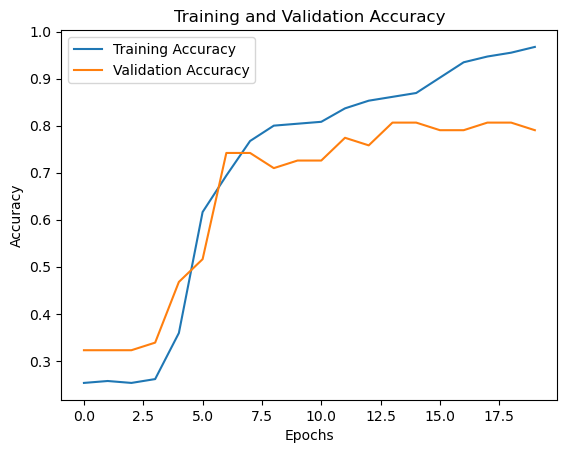

In [9]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### **Model 1**: Original Architecture with Fine-Tuned Hyperparameters

>The following code snippet saves the trained model to a file named `model_fine_tuned.keras`. This stores the model's architecture, weights, and optimizer configuration.


In [10]:
# Save the trained model to a file'
model.save('models/cnn_hypertuned.keras')

### Evaluate the Model and Generate Classification Report

>Evaluate the trained model on the test dataset, calculate the test loss and accuracy, and print them for reference. The model's predictions (`y_pred`) on the test set are  converted from one-hot encoded format to class labels. These predictions are compared with the true class labels (`y_true_classes`) to generate a detailed classification report and confusion matrix using `sklearn.metrics`. The classification report includes precision, recall, F1-score, and support for each class, while the confusion matrix provides a breakdown of the model's performance for each class by showing the counts of true positives, false positives, true negatives, and false negatives.


In [11]:
y_pred = model.predict(x_test)

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report, confusion_matrix

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 - 0s - 81ms/step - accuracy: 0.7792 - loss: 0.7242
Test Loss: 0.724226176738739
Test Accuracy: 0.7792207598686218
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        27
           1       0.82      0.90      0.86        20
           2       0.86      0.80      0.83        15
           3       0.62      0.67      0.65        15

    accuracy                           0.78        77
   macro avg       0.78      0.78      0.77        77
weighted avg       0.78      0.78      0.78        77

[[20  2  1  4]
 [ 1 18  0  1]
 [ 1  1 12  1]
 [ 3  1  1 10]]


### **Model 2**: Original Architecture with Dropout Layers

The following code defines a Convolutional Neural Network (CNN) using the best hyperparameters obtained from Keras Tuner. The model incorporates dropout layers to prevent overfitting and enhance performance. 

1. **Model Definition**:
   - **Convolutional Layers**: Two `Conv2D` layers with 96 and 64 filters respectively, followed by `MaxPooling2D` layers.
   - **Dropout Layers**: Two `Dropout` layers with a dropout rate of 0.5, added to help mitigate overfitting.
   - **Dense Layers**: A fully connected `Dense` layer with 128 units, followed by a final `Dense` layer with 4 units for classification.

2. **Compilation**:
   - The model is compiled with the Adam optimizer, using specific hyperparameters including learning rate, beta values, and epsilon, to optimize the training process.

3. **Training**:
   - The model is trained on the training dataset for 20 epochs, with validation data provided for monitoring.

4. **Evaluation**:
   - The model’s performance is evaluated on both the validation and test datasets. Metrics including loss and accuracy are printed.
   - Predictions are made on the test set, and classification reports along with confusion matrices are generated to assess the model's performance in detail.



Epoch 1/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.2836 - loss: 2.1764 - val_accuracy: 0.2581 - val_loss: 1.4441
Epoch 2/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.2781 - loss: 1.4651 - val_accuracy: 0.2581 - val_loss: 1.3799
Epoch 3/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.2440 - loss: 1.4158 - val_accuracy: 0.3226 - val_loss: 1.3725
Epoch 4/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.3677 - loss: 1.3594 - val_accuracy: 0.3387 - val_loss: 1.3616
Epoch 5/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.4545 - loss: 1.3195 - val_accuracy: 0.3387 - val_loss: 1.3340
Epoch 6/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.5136 - loss: 1.2458 - val_accuracy: 0.5000 - val_loss: 1.2798
Epoch 7/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.6335 - loss: 1.1112 - val_accuracy: 0.6774 - val_loss: 1.1969
Epoch 8/21
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.6645 - loss: 0.9632 - val_accuracy: 0.6613 - val_loss:

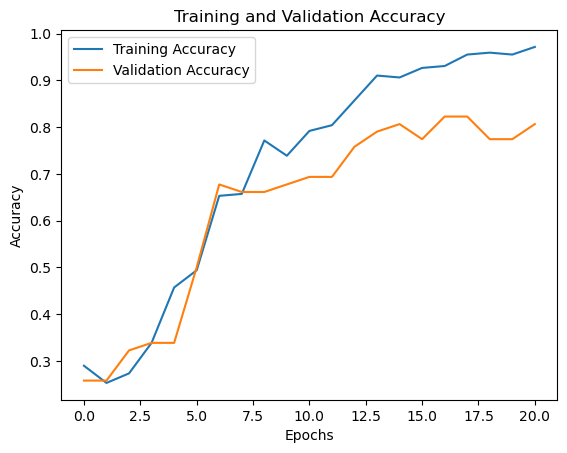

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 - 0s - 68ms/step - accuracy: 0.8052 - loss: 0.7374
Test Loss: 0.7373673319816589
Test Accuracy: 0.8051947951316833
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        27
           1       1.00      0.90      0.95        20
           2       0.81      0.87      0.84        15
           3       0.67      0.67      0.67        15

    accuracy                           0.81        77
   macro avg       0.81      0.80      0.80        77
weighted avg       0.81      0.81      0.81        77

[[21  0  3  3]
 [ 1 18  0  1]
 [ 1  0 13  1]
 [ 5  0  0 10]]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


# Define the model
model_skeleton = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='valid', name='conv2d_2'),
    MaxPooling2D((2, 2), name='max_pooling2d_2'),
    Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv2d_3'),
    Dropout(0.5),
    MaxPooling2D((2, 2), name='max_pooling2d_3'),
    Flatten(name='flatten_1'),
    Dense(128, activation='relu', name='dense_2'),
    Dropout(0.5),
    Dense(4, activation='softmax', name='dense_3')
])

# Compile the model
optimizer = Adam(
    learning_rate=0.00018328792004345589,
    beta_1=0.9700000000000001,
    beta_2=0.9540000000000001,
    epsilon=3.3137745378583986e-07
)

model_skeleton.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training data and validate using the validation set
history = model_skeleton.fit(
    x_train, y_train, 
    epochs=21, 
    validation_data=(x_val, y_val), 
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_skeleton.evaluate(x_val, y_val)

# Print validation loss and accuracy
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Evaluate the trained model on the test dataset
y_pred = model_skeleton.predict(x_test)
test_loss, test_accuracy = model_skeleton.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))

# Save the trained model to a file'
model_skeleton.save('models/cnn_hypertuned_dropout.keras')

In [13]:
# Save the model architecture to a JSON file
model_json = model_skeleton.to_json()
with open("optimized_cnn_model_architecture.json", "w") as json_file:
    json_file.write(model_json)


### **Model 3**: Optimized CNN with Data Augmentation

**Description**: This model features an optimized CNN architecture with data augmentation. 

- **File Name**: `optimized_cnn_with_augmentation_early_stopping.keras`
- **JSON Architecture File**: `optimized_cnn_with_augmentation_early_stopping.json`

**Details:**
- **Architecture**: 
  - Conv2D layers with ReLU activation
  - MaxPooling2D layers
  - Dropout layers to mitigate overfitting
  - Dense layers for final classification
- **Optimizer**: Adam with a learning rate of 0.0001
- **Data Augmentation**: Utilizes `ImageDataGenerator` for training data



Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.2137 - loss: 1.6819 - val_accuracy: 0.1935 - val_loss: 1.3906
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.1891 - loss: 1.5488 - val_accuracy: 0.3065 - val_loss: 1.3763
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.2782 - loss: 1.3959 - val_accuracy: 0.2581 - val_loss: 1.3737
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.2723 - loss: 1.3829 - val_accuracy: 0.2581 - val_loss: 1.3739
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.2988 - loss: 1.3725 - val_accuracy: 0.4032 - val_loss: 1.3765
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.2859 - loss: 1.3796 - val_accuracy: 0.2581 - val_loss: 1.3622
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.3206 - loss: 1.3492 - val_accuracy: 0.4516 - val_loss: 1.3633
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.3205 - loss: 1.3555 - val_accuracy: 0.3871 - v

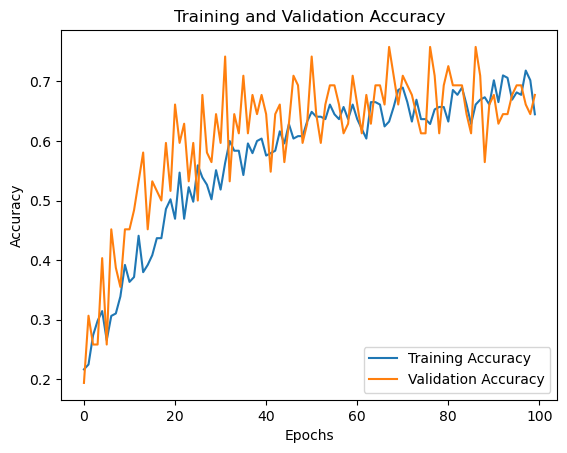

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step WARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002898F8D99D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
3/3 - 0s - 133ms/step - accuracy: 0.7013 - loss: 1.0000
Test Loss: 1.0000030994415283
Test Accuracy: 0.701298713684082
              precision    recall  f1-score   support

           0       0.70 

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the model
model_skeleton = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='valid', name='conv2d_2'),
    MaxPooling2D((2, 2), name='max_pooling2d_2'),
    Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv2d_3'),
    Dropout(0.5),
    MaxPooling2D((2, 2), name='max_pooling2d_3'),
    Flatten(name='flatten_1'),
    Dense(128, activation='relu', name='dense_2'),
    Dropout(0.5),
    Dense(4, activation='softmax', name='dense_3')
])

model_skeleton.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the data augmentation generator to your training data
datagen.fit(x_train)

# Create data generators for training and validation
train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = datagen.flow(x_val, y_val, batch_size=32)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',   
    patience=20,           
    restore_best_weights=True )

# Train the model with the augmented data and early stopping
history = model_skeleton.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=100,
    validation_data=val_generator,

)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_skeleton.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the trained model on the test dataset
y_pred = model_skeleton.predict(x_test)
test_loss, test_accuracy = model_skeleton.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))

# Save the trained model to a file
model_skeleton.save('models/cnn_aug.keras')


## Summary and Recommendations

### *Model 2: `cnn_hypertuned_dropout`*
- *Best Performance*: Overall with the highest test accuracy (81.8%) and relatively balanced precision and recall across classes.
- *Recommendation*: This model is likely the best choice as it performs well across most metrics, particularly in terms of test accuracy.

### *Model 1: `cnn_hypertuned`*
- *Good Performance*: With decent accuracy and balanced precision/recall, but slightly lower than Model 2.
- *Recommendation*: This model is a strong contender but does not outperform Model 2 in terms of accuracy.

### *Model 3: `cnn_aug`*
- *Lower Performance*: With the lowest accuracy and higher loss values, suggesting that data augmentation might not have improved performance in this case.
- *Recommendation*: This model is less effective compared to the others and may not be the best choice.

Based on these comparisons, *Model 2 (`cnn_hypertuned_dropout`)* is the most effective model among the three, considering its higher accuracy and balanced performance metrics.
